# Fuzzy ART utilizando a função VAT

Aqui, embaralharemos os dados e avaliaremos o modelo usando a métrica ARI.

## Importando bibliotecas

In [47]:
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import adjusted_rand_score
from pyclustertend import vat
from artlib import FuzzyART
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Baixando base de dados

In [48]:
transform = transforms.ToTensor()
dataset = datasets.USPS(root='./data', train=True, download=True, transform=transform)

X = np.stack([img.numpy().squeeze() for img, _ in dataset])  # (N, 16, 16)
y = np.array([label for _, label in dataset])

print("Dimensões originais:", X.shape)

# Achatando dados
nsamples, h, w = X.shape
X_flat = X.reshape((nsamples, h * w))

# Normalizando
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_flat)

Dimensões originais: (7291, 16, 16)


### Aplicando VAT

Matriz ODM (Ordered Dissimilarity): (2000, 2000)


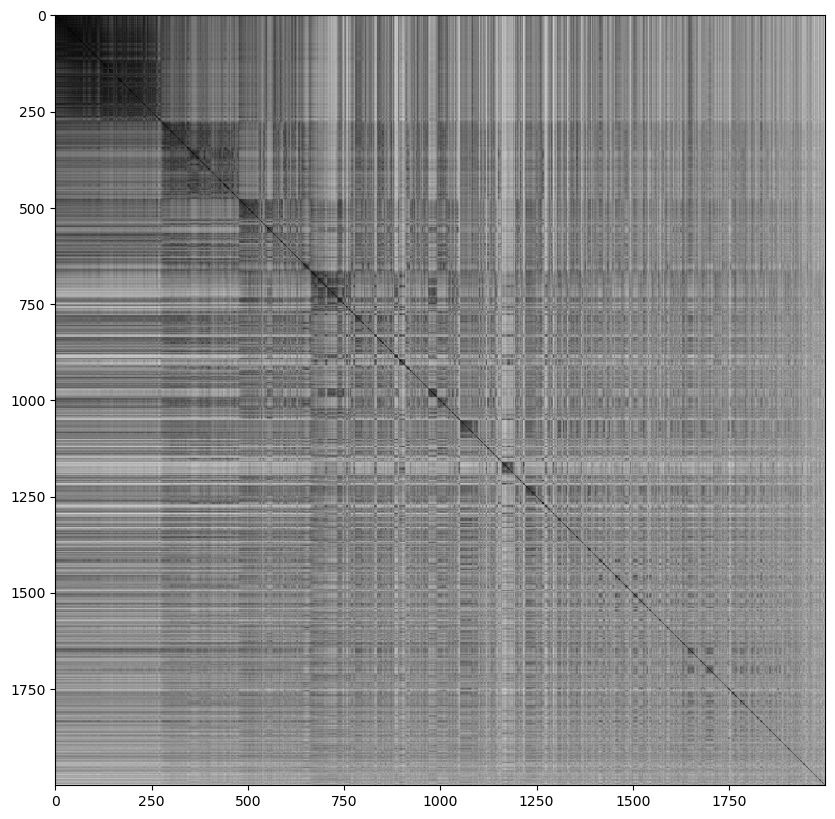

In [49]:
X_sample = resample(X_scaled, n_samples=2000, random_state=42)

ODM = vat(X_sample, return_odm=True)
print("Matriz ODM (Ordered Dissimilarity):", ODM.shape)

### Dividindo entre treino e teste

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=0
)
print("Treino:", X_train.shape, "Teste:", X_test.shape)

Treino: (4374, 256) Teste: (2917, 256)


## Treinando o modelo

In [51]:
alphas = [1e-6, 1.0, 10.0] 
rhos   = [0.1, 0.5, 0.9]
betas  = [1.0, 0.5, 0.1]

results = []

for alpha in alphas:
    for rho in rhos:
        for beta in betas:

            model = FuzzyART(rho=rho, alpha=alpha, beta=beta)
            
            lower_bound, upper_bound = model.find_data_bounds(X_train)
            model.set_data_bounds(lower_bound, upper_bound)

            # Preparar os dados (normalizados internamente pelo modelo)
            train_X_prep = model.prepare_data(X_train)
            test_X_prep  = model.prepare_data(X_test)

            # Treinar
            model.fit(train_X_prep)

            # Prever
            predictions = model.predict(test_X_prep)

            # Calcular accuracy
            ari = adjusted_rand_score(y_test, predictions)

            results.append({
                'alpha': alpha,
                'rho': rho,
                'beta': beta,
                'ARI': ari
            })

            #print(f"alpha={alpha:.1e}, rho={rho}, beta={beta} → acc={acc:.3f}")

df_results = pd.DataFrame(results)
best_results = df_results.sort_values(by='ARI', ascending=False).head(10)


AssertionError: Data has not been normalized

In [52]:
print("10 melhores combinações:")
print(best_results)

10 melhores combinações:


NameError: name 'best_results' is not defined